<a href="https://colab.research.google.com/github/EllenRochester/TextAnalytics/blob/main/TextAnalytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.Import *

In [ ]:
import numpy as np
import tensorflow as tf
tf.config.list_physical_devices('GPU') # list available GPU

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics as metrics
import seaborn as sn

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
from tensorflow import keras
from tensorflow.keras.utils import text_dataset_from_directory
from tensorflow.keras.layers import Input, Dense, Embedding, Dropout, TextVectorization, Bidirectional, GlobalMaxPooling1D, GRU

import matplotlib.pyplot as plt
def plotEpoch( history, metric='acc'):
    epochs = range(len(history['loss']))
    if metric=='acc':
        plt.plot(epochs, history['accuracy'], 'k', label='Training acc')
        val = history['val_accuracy']
        plt.plot(epochs, val, 'b', label='Validation acc')
        plt.axvline(x=val.index(max(val)), color='r')
        plt.title('Training and validation accuracy')
        plt.legend()
        plt.figure()
    elif metric=='loss':
        plt.plot(epochs, history['loss'], 'k', label='Training loss')
        val = history['val_loss']
        plt.plot(epochs, val, 'b', label='Validation loss')
        plt.axvline(x=val.index(min(val)), color='r')
        plt.title('Training and validation loss')
        plt.legend()
        plt.show()

# 2.Load and Process Data *

In [ ]:
drRatings = pd.read_excel('./OBGYN_new_train_80000.xlsx')
#shuffle the data so that they are in random sequence
drRatings = drRatings.sample(frac=1)
drRatings['highKnowledge'] = (drRatings['knowledge']>4).astype(int)
drRatings.head()

,reviewID,doctorID,doctorName,specialty,numReviews,city,state,doctorHomepage,averageRating,staff,punctuality,helpfulness,knowledge,postedTime,review,review_helpful_count,highKnowledge
79962,79963,3377781,Dr. Melissa I. Lee,Gynecologist (OBGYN),10,Fort Myers,FL,/doctor-ratings/3377781/Dr-MELISSA%2BI.-LEE-Fo...,4.75,4,5,5,5,2012-08-27 08:52:00,Best Doctor i have ever had. Im a first time m...,0,1
33201,33202,130320,Dr. Robert F. Mohr,Gynecologist (OBGYN),11,Randolph,NJ,/doctor-ratings/130320/Dr-Robert%2BF.-Mohr-Ran...,4.75,5,4,5,5,2007-12-18 20:33:00,"The best most wonderful, caring, compassionate...",0,1
51329,51330,91091,Dr. Maria I. Perales,Gynecologist (OBGYN),14,Nashville,TN,/doctor-ratings/91091/Dr-Maria%2BI.-Perales-Na...,5.00,0,5,5,5,2007-04-21 00:00:00,Dr. Perales is a wonderful doctor who cares ve...,0,1
72621,72622,93772,Dr. Patricia M. Barwig,Gynecologist (OBGYN),8,Brookfield,WI,/doctor-ratings/93772/Dr-Patricia%2BM.-Barwig-...,5.00,5,5,5,5,2008-11-13 16:36:00,I have been seeing Dr. Barwig for 20 years and...,0,1
69861,69862,101658,Dr. Anne M. Kent,Gynecologist (OBGYN),13,Newport Beach,CA,/doctor-ratings/101658/Dr-Anne%2BM.-Kent-Newpo...,1.50,1,1,2,2,2009-06-03 20:33:00,"initial visit was good, follow up (waited over...",1,0


In [ ]:
import re
from sklearn import feature_extraction
stop_words = feature_extraction.text.ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

def preprocess(text):
  text = text.lower() #lowercase
  text = re.sub(r'[^\w\s]', '', text) #remove punctuations
  text = re.sub(r'\d+', '', text) #remove numbers
  text = " ".join(text.split()) #stripWhitespace
  text = text.split()
  text = [x for x in text if x not in stop_words] #remove stopwords
  text = [x for x in text if x not in ["dr", "doctor"]] #remove task specific stopwords
  text = " ".join(text)
  # stemmer_ps = PorterStemmer()
  # text = [stemmer_ps.stem(word) for word in text.split()] #stemming
  # text = " ".join(text)
  # lemmatizer = WordNetLemmatizer()
  # text = [lemmatizer.lemmatize(word) for word in text.split()]  #lemmatization
  # text = " ".join(text)
  return(text)

In [ ]:
drRatings['text'] = drRatings['review'].apply(lambda x:preprocess(x))
drRatings['text']

79962    best im time mom high risk pregnancy lee gone ...
33201    best wonderful caring compassionate oneofakind...
51329    perales wonderful cares patients helped delive...
72621    seeing barwig years thinks great takes time li...
69861    initial visit good follow waited hour appts go...
                               ...                        
70235    ive gone rock gynecologist years really like r...
61936    happier experience jason perfectionist kind ca...
59230    far worst practice time moms office reception ...
22932    shaktman brillaint gives right answers dont wa...
76864    gapinski delivered children wonderful great be...
Name: text, Length: 80000, dtype: object

In [ ]:
texts = drRatings['text'].tolist()
labels = drRatings['highKnowledge'].tolist()

In [ ]:
# Build TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((texts, labels))

In [ ]:
#Specify batch size
batch_size = 32
dataset = dataset.batch(batch_size)

In [ ]:
# Cache data and prefetch data to improve performance
AUTOTUNE = tf.data.AUTOTUNE
dataset = dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Split the data set into training set and validation set
total_batches = 1250
train_size = int(0.85 * total_batches)
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size)

In [ ]:
print(train_ds.cardinality().numpy())
print(val_ds.cardinality().numpy())

1062
1438


In [ ]:
total_batches = tf.data.experimental.cardinality(dataset).numpy()
print("Total number of batches in the dataset:", total_batches)


Total number of batches in the dataset: 2500


In [ ]:
text_only_train_ds = train_ds.map(lambda x, y: x)
vocab_size = 20000

# 3.Sequence Data Preparation *

In [ ]:
# calculate text length
def compute_text_length(text):
    return tf.strings.length(text)

text_lengths_ds = train_ds.map(lambda x, y: (compute_text_length(x), y))

mean_text_length = np.mean([length.numpy() for length, _ in text_lengths_ds])
max_text_length = np.max([length.numpy() for length, _ in text_lengths_ds])

print("Mean text length:", mean_text_length)
print("Max text length:", max_text_length)

Mean text length: 200.79163724105462
Max text length: 2719


In [ ]:
seq_len = 300
text_vectorization = TextVectorization( max_tokens=vocab_size, output_sequence_length=seq_len, output_mode="int" )
text_vectorization.adapt( text_only_train_ds )

In [ ]:
int_train_ds = train_ds.map( lambda x, y: (text_vectorization(x), y),  num_parallel_calls=4 ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
int_val_ds = val_ds.map( lambda x, y: (text_vectorization(x), y),  num_parallel_calls=4 ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
inputs = tf.keras.Input(shape=(seq_len,), dtype="int64")

In [ ]:
text_vectorization.adapt(text_only_train_ds)


In [ ]:
print(len(text_vectorization.get_vocabulary()))


20000


In [ ]:
inputs = tf.keras.Input(shape=(seq_len,), dtype="int64")


# 4.1 RNN

## 4.1 Embedding + Bidirectional LSTM

In [ ]:
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dropout, Dense

In [ ]:
x = Embedding( input_dim=vocab_size, output_dim=100 )(inputs)
x = Bidirectional(GRU(32))(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(inputs, outputs)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 300)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 300, 100)            │       2,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,025,793 (7.73 MB)

 Trainable params: 2,025,793 (7.73 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - accuracy: 0.8323 - loss: 0.3696 - val_accuracy: 0.9084 - val_loss: 0.2519
Epoch 2/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9167 - loss: 0.2340 - val_accuracy: 0.9131 - val_loss: 0.2474
Epoch 3/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 24s 24ms/step - accuracy: 0.9250 - loss: 0.2174 - val_accuracy: 0.9118 - val_loss: 0.2513
Epoch 4/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9305 - loss: 0.2045 - val_accuracy: 0.9099 - val_loss: 0.2599
Epoch 5/5
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 22s 22ms/step - accuracy: 0.9352 - loss: 0.1941 - val_accuracy: 0.9087 - val_loss: 0.2654


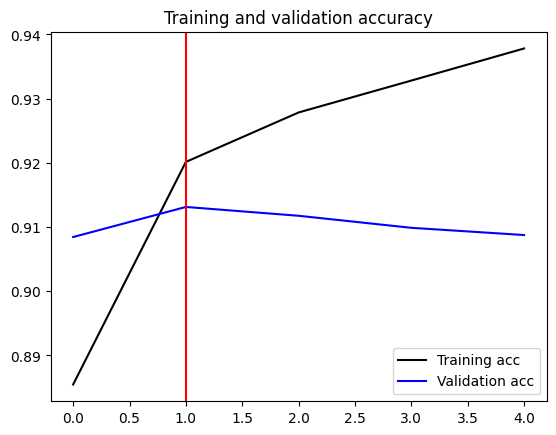

<Figure size 640x480 with 0 Axes>

In [ ]:
model.compile( optimizer="rmsprop", loss="binary_crossentropy", metrics=["accuracy"] )
callbacks = [tf.keras.callbacks.ModelCheckpoint("models/imdb_gru.keras", save_best_only=True)]
history = model.fit( int_train_ds, validation_data=int_val_ds, epochs=5, callbacks = callbacks )
plotEpoch( history.history )

# 4.2 Transformer

In [ ]:
from transformer import Encoder, PositionalEmbedding

Transformer imported from local file "transformer.py"


In [ ]:
d_emb = 128
x = PositionalEmbedding(vocab_size, d_emb)(inputs)
x = Encoder( n_layers=1, d_emb=d_emb, n_heads=1, d_ff=32 )(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile( optimizer="rmsprop", loss="binary_crossentropy",  metrics=["accuracy"] )

In [ ]:
history = model.fit( int_train_ds, validation_data=int_val_ds, epochs=3 )
plotEpoch( history.history )

Epoch 1/3
1000/1000 [==============================] - 43s 37ms/step - loss: 0.3073 - accuracy: 0.8811 - val_loss: 0.2426 - val_accuracy: 0.9133


KeyboardInterrupt: 

Epoch 1/8
1000/1000 [==============================] - 44s 40ms/step - loss: 0.3044 - accuracy: 0.8809 - val_loss: 0.2376 - val_accuracy: 0.9142
Epoch 2/8
1000/1000 [==============================] - 20s 20ms/step - loss: 0.2286 - accuracy: 0.9195 - val_loss: 0.2360 - val_accuracy: 0.9146
Epoch 3/8
1000/1000 [==============================] - 21s 21ms/step - loss: 0.2143 - accuracy: 0.9258 - val_loss: 0.2449 - val_accuracy: 0.9159
Epoch 4/8
1000/1000 [==============================] - 21s 21ms/step - loss: 0.2045 - accuracy: 0.9296 - val_loss: 0.2513 - val_accuracy: 0.9134
Epoch 5/8
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1903 - accuracy: 0.9366 - val_loss: 0.2937 - val_accuracy: 0.8986
Epoch 6/8
1000/1000 [==============================] - 20s 20ms/step - loss: 0.2006 - accuracy: 0.9318 - val_loss: 0.3051 - val_accuracy: 0.9015
Epoch 7/8
1000/1000 [==============================] - 20s 20ms/step - loss: 0.1975 - accuracy: 0.9316 - val_loss: 0.3212 - val_ac

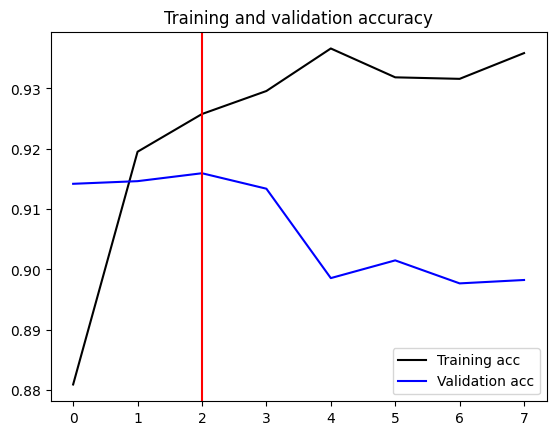

<Figure size 640x480 with 0 Axes>

In [ ]:
d_emb = 128
x = PositionalEmbedding(vocab_size, d_emb)(inputs)
x = Encoder( n_layers=1, d_emb=d_emb, n_heads=3, d_ff=32 )(x)
x = GlobalMaxPooling1D()(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile( optimizer="rmsprop", loss="binary_crossentropy",  metrics=["accuracy"] )
history = model.fit( int_train_ds, validation_data=int_val_ds, epochs=8 )
plotEpoch( history.history )

### 4.2.1 GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
import tensorflow as tf

# Define your model function
def create_model(learning_rate=0.01, optimizer='adam', n_layers=1, d_emb=128, n_heads=1, d_ff=32):
    inputs = tf.keras.Input(shape=(seq_len,), dtype="int64")
    x = PositionalEmbedding(vocab_size, d_emb)(inputs)
    x = Encoder(n_layers=n_layers, d_emb=d_emb, n_heads=n_heads, d_ff=d_ff)(x)
    x = GlobalMaxPooling1D()(x)
    x = Dropout(0.5)(x)
    outputs = Dense(1, activation="sigmoid")(x)
    model = tf.keras.Model(inputs, outputs)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Create KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# Define the grid search parameters
param_grid = {
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['adam', 'rmsprop'],
    'n_layers': [1, 2, 3],
    'd_emb': [64, 128, 256],
    'n_heads': [1, 2, 4],
    'd_ff': [32, 64, 128]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid_search.fit(int_train_ds)

# Print results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


# 4.3 BERT Pretrained Models *

In [ ]:
!pip install -U "tensorflow-text==2.15.0"
!pip install -U "tf-models-official==2.15.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 40.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 33.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16161 sha256=7a9b6f53ca04d00646ad71177254a101bf36e0bb9fbca3a394bb82194d755ba0
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
import tensorflow_hub as hub
import tensorflow_text
from official.nlp import optimization
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
# @title
map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base': 'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small': 'https://tfhub.dev/google/electra_small/2',
    'electra_base': 'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed': 'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books': 'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base': 'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1', }

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12': 'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base': 'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base': 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3', }

# Final Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


checkpoint_filepath = './model_checkpoint/bert_model_epoch_{epoch}.h5'

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    save_best_only=False,
    verbose=1
)

Epoch 1/2
1062/1062 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.8763
Epoch 1: saving model to ./model_checkpoint/bert_model_epoch_1.h5
1062/1062 [==============================] - 417s 377ms/step - loss: 0.2920 - accuracy: 0.8763 - val_loss: 0.2234 - val_accuracy: 0.9122
Epoch 2/2
1062/1062 [==============================] - ETA: 0s - loss: 0.1774 - accuracy: 0.9421
Epoch 2: saving model to ./model_checkpoint/bert_model_epoch_2.h5
1062/1062 [==============================] - 399s 376ms/step - loss: 0.1774 - accuracy: 0.9421 - val_loss: 0.2359 - val_accuracy: 0.9233


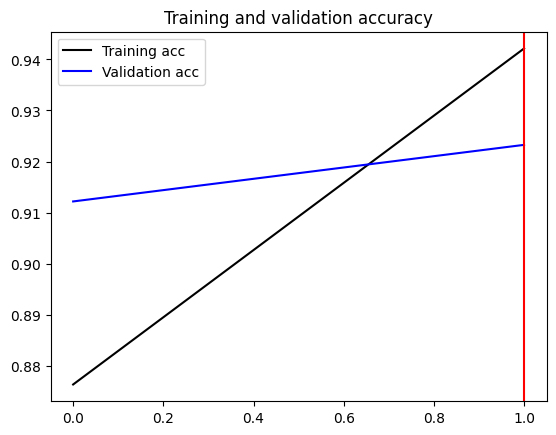

<Figure size 640x480 with 0 Axes>

In [ ]:
bert_model_name = 'bert_en_uncased_L-12_H-768_A-12'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
bert_model = hub.KerasLayer(tfhub_handle_encoder)
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

def build_bert_classifier():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

bert_classifier = build_bert_classifier()
epochs = 2
steps_per_epoch = len(train_ds) # or use tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=3e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bert_classifier.compile( optimizer=optimizer, loss=loss,  metrics=["accuracy"]  )

history = bert_classifier.fit( train_ds, validation_data=val_ds, epochs=epochs, callbacks=[model_checkpoint_callback])
plotEpoch( history.history )

In [ ]:
bert_classifier_same = build_bert_classifier()


bert_classifier_same.load_weights('./model_checkpoint/bert_model_epoch_2.h5')



# Build function of Bert *

In [ ]:
#build function of Bert

def train_bert_classifier(bert_model_name, epochs=1):
    # Get the TensorFlow Hub handles for the specified BERT model
    tfhub_handle_encoder = map_name_to_handle[bert_model_name]
    tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

    # Define the input layer for the text
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # Preprocess the input text using the preprocessing layer from TensorFlow Hub
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)

    # Load the BERT encoder model from TensorFlow Hub
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)

    # Get the pooled output from BERT
    net = outputs['pooled_output']

    # Add a dropout layer for regularization
    net = tf.keras.layers.Dropout(0.1)(net)

    # Add a dense layer for binary classification
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)

    # Define the model with input and output layers
    bert_classifier = tf.keras.Model(text_input, net)

    # Compile the model with an optimizer, loss function, and evaluation metrics
    optimizer = optimization.create_optimizer(init_lr=3e-5, num_train_steps=len(train_ds) * epochs,
                                              num_warmup_steps=int(0.1 * (len(train_ds) * epochs)),
                                              optimizer_type='adamw')
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    bert_classifier.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])

    # Train the model on the provided datasets
    history = bert_classifier.fit(train_ds, validation_data=val_ds, epochs=epochs)


# L-4_H-512_A-8

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
bert_model = hub.KerasLayer(tfhub_handle_encoder)
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
def build_bert_classifier():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [ ]:
bert_classifier = build_bert_classifier()
epochs = 3
steps_per_epoch = len(train_ds) # or use tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
optimizer = optimization.create_optimizer(init_lr=3e-5, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
bert_classifier.compile( optimizer=optimizer, loss=loss,  metrics=["accuracy"]  )

Epoch 1/3
1000/1000 [==============================] - 366s 354ms/step - loss: 0.2941 - accuracy: 0.8777 - val_loss: 0.2352 - val_accuracy: 0.9162
Epoch 2/3
1000/1000 [==============================] - 352s 352ms/step - loss: 0.2147 - accuracy: 0.9209 - val_loss: 0.2261 - val_accuracy: 0.9193
Epoch 3/3
1000/1000 [==============================] - 347s 347ms/step - loss: 0.1888 - accuracy: 0.9333 - val_loss: 0.2319 - val_accuracy: 0.9201


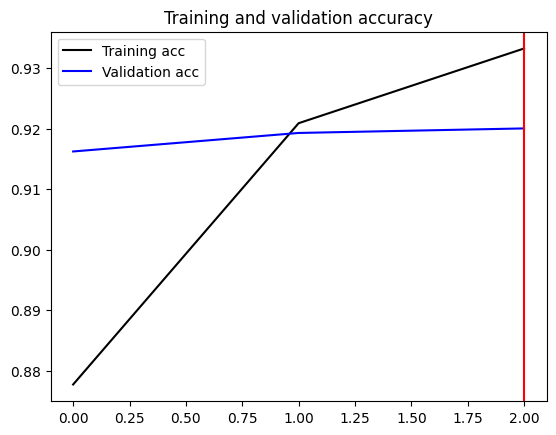

<Figure size 640x480 with 0 Axes>

In [ ]:
history = bert_classifier.fit( train_ds, validation_data=val_ds, epochs=epochs)
plotEpoch( history.history )

# H-128 - 0.8991

In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-2_H-128_A-2')

1000/1000 [==============================] - 250s 247ms/step - loss: 0.3816 - accuracy: 0.8230 - val_loss: 0.2874 - val_accuracy: 0.8789


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-4_H-128_A-2')

1000/1000 [==============================] - 316s 308ms/step - loss: 0.3506 - accuracy: 0.8398 - val_loss: 0.2765 - val_accuracy: 0.8905


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-6_H-128_A-2')

1000/1000 [==============================] - 294s 285ms/step - loss: 0.3616 - accuracy: 0.8328 - val_loss: 0.2763 - val_accuracy: 0.8937


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-8_H-128_A-2')

1000/1000 [==============================] - 268s 258ms/step - loss: 0.3306 - accuracy: 0.8503 - val_loss: 0.2645 - val_accuracy: 0.8991


# H-256 - 0.9086

In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-2_H-256_A-4')

1000/1000 [==============================] - 282s 277ms/step - loss: 0.3187 - accuracy: 0.8572 - val_loss: 0.2635 - val_accuracy: 0.8982


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-4_H-256_A-4')

1000/1000 [==============================] - 305s 299ms/step - loss: 0.3101 - accuracy: 0.8637 - val_loss: 0.2557 - val_accuracy: 0.9039


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-8_H-256_A-4')

1000/1000 [==============================] - 346s 336ms/step - loss: 0.2965 - accuracy: 0.8713 - val_loss: 0.2456 - val_accuracy: 0.9086


# H-512 - 0.9149

In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-2_H-512_A-8')

1000/1000 [==============================] - 279s 273ms/step - loss: 0.2906 - accuracy: 0.8756 - val_loss: 0.2441 - val_accuracy: 0.9096


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-6_H-512_A-8')

1000/1000 [==============================] - 383s 373ms/step - loss: 0.2726 - accuracy: 0.8885 - val_loss: 0.2301 - val_accuracy: 0.9149


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-8_H-512_A-8')

1000/1000 [==============================] - 462s 452ms/step - loss: 0.2694 - accuracy: 0.8881 - val_loss: 0.2276 - val_accuracy: 0.9149


# H-768 - 0.9229 *

In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-6_H-768_A-12',3)

In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-10_H-768_A-12',3)

Epoch 1/3
1000/1000 [==============================] - 703s 691ms/step - loss: 0.2780 - accuracy: 0.8832 - val_loss: 0.2156 - val_accuracy: 0.9156
Epoch 2/3
1000/1000 [==============================] - 687s 687ms/step - loss: 0.1896 - accuracy: 0.9335 - val_loss: 0.2141 - val_accuracy: 0.9231
Epoch 3/3
1000/1000 [==============================] - 685s 685ms/step - loss: 0.1498 - accuracy: 0.9503 - val_loss: 0.2255 - val_accuracy: 0.9254


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-12_H-768_A-12',2)

Epoch 1/2
1000/1000 [==============================] - 812s 788ms/step - loss: 0.2659 - accuracy: 0.8914 - val_loss: 0.2196 - val_accuracy: 0.9221
Epoch 2/2
1000/1000 [==============================] - 789s 789ms/step - loss: 0.1813 - accuracy: 0.9371 - val_loss: 0.2171 - val_accuracy: 0.9246


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-12_H-512_A-8',2)

Epoch 1/2
1000/1000 [==============================] - 558s 541ms/step - loss: 0.2728 - accuracy: 0.8882 - val_loss: 0.2186 - val_accuracy: 0.9201
Epoch 2/2
1000/1000 [==============================] - 537s 537ms/step - loss: 0.1935 - accuracy: 0.9309 - val_loss: 0.2174 - val_accuracy: 0.9221


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-12_H-128_A-2',1)

1000/1000 [==============================] - 306s 286ms/step - loss: 0.3209 - accuracy: 0.8582 - val_loss: 0.2555 - val_accuracy: 0.9014


In [ ]:
train_bert_classifier('small_bert/bert_en_uncased_L-12_H-256_A-4',1)

1000/1000 [==============================] - 360s 344ms/step - loss: 0.2889 - accuracy: 0.8790 - val_loss: 0.2372 - val_accuracy: 0.9115


In [ ]:
#
train_bert_classifier('bert_en_uncased_L-12_H-768_A-12',1)

1000/1000 [==============================] - 800s 784ms/step - loss: 0.2540 - accuracy: 0.8969 - val_loss: 0.2129 - val_accuracy: 0.9229


In [ ]:
train_bert_classifier('bert_en_cased_L-12_H-768_A-12',1)

1000/1000 [==============================] - 860s 845ms/step - loss: 0.2575 - accuracy: 0.8957 - val_loss: 0.2135 - val_accuracy: 0.9222


# 5.Predict for Testing data

In [ ]:
drRatings_test = pd.read_excel('/content/OBGYN_new_test_withoutAnswer_20000_2024.xlsx')
drRatings_test.head()

,reviewID,doctorID,doctorName,specialty,numReviews,city,state,doctorHomepage,postedTime,review,review_helpful_count
0,80001,106417,Dr. Daniel E. Bahnmiller,Gynecologist (OBGYN),22,Richland,WA,/doctor-ratings/106417/Dr-Daniel%2BE.-Bahnmill...,2010-09-10 22:00:00,Very friendly and helpful staff and doctor. Do...,0
1,80002,31663,Dr. Donald P. Ward,Gynecologist (OBGYN),8,Austin,TX,/doctor-ratings/31663/Dr-Donald%2BP.-Ward-Aust...,2007-01-16 13:13:00,Dr. Ward is very professional and at the same ...,0
2,80003,2244002,Dr. James R. Gullett,Gynecologist (OBGYN),2,Houston,TX,/doctor-ratings/2244002/Dr-JAMES%2BR.-GULLETT-...,2013-05-26 08:55:00,"Dr Gullett is an excellent Doctor, and his sta...",0
3,80004,16966,Dr. Henry Y. Su,Gynecologist (OBGYN),17,HOUSTON,TX,/doctor-ratings/16966/Dr-Henry%2BY.-Su-HOUSTON...,2009-05-22 13:57:00,"He seems really nice, he is partnred w/ Dr. Mu...",0
4,80005,919,Dr. Judith A. Gurdian,Gynecologist (OBGYN),38,ROCKVILLE,MD,/doctor-ratings/919/Dr-Judith%2BA.-Gurdian-ROC...,2012-04-13 16:56:00,What a wonderful doctor. I am a very high risk...,0


In [ ]:
drRatings_test['text'] = drRatings_test['review'].apply(lambda x:preprocess(x))
drRatings_test['text']

0        friendly helpful staff listens questions recom...
1        ward professional time kind thoughtful gentle ...
2        gullett excellent staff great especially head ...
3        really nice partnred w mundy caring understand...
4        wonderful high risk patient rare bleeding diso...
                               ...                        
19995    perforemed amniocetesis procedure unnecessary ...
19996    schlinke staff gentle caring answering questio...
19997    seeing yium years just recently pregnant excit...
19998    watch records unprofessional best obgyn area w...
19999                                           shes great
Name: text, Length: 20000, dtype: object

In [ ]:
texts = drRatings_test['text'].tolist()

In [ ]:
# Build TensorFlow Dataset
test_ds = tf.data.Dataset.from_tensor_slices(texts)

In [ ]:
test_ds = test_ds.batch(32)

In [ ]:
bert_classifier_same = build_bert_classifier()
bert_classifier_same.load_weights('./model_checkpoint/bert_model_epoch_2.h5')


predictions = bert_classifier_same.predict(test_ds)


import numpy as np
pred = (tf.sigmoid(predictions).numpy().flatten() > 0.5).astype(int)

313/313 [==============================] - 73s 230ms/step


In [ ]:

submitcsv = pd.DataFrame()
submitcsv['reviewID'] = drRatings_test['reviewID'].tolist()
submitcsv['prediction'] = pred
submitcsv.to_csv('submission.csv', index=False)
print(submitcsv.head())


   reviewID  prediction
0     80001           1
1     80002           1
2     80003           1
3     80004           1
4     80005           1
